### CH15 Processing Sequence Using RNNs and CNNs 

In [1]:
# P648 - P681

In [2]:
# set up 

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os
from pathlib import Path

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

No GPU was detected. LSTMs and CNNs can be very slow without a GPU.


In [12]:
### Forecasting a Time Series 

# define time series 

def generate_time_series(batch_size, n_steps): 
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1) 
    time = np.linspace(0, 1, n_steps) 
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10)) # wave 1 
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) #  + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5) # + noise 
    return series[..., np.newaxis].astype(np.float32) 

# create dataset 

n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

Saving figure time_series_plot


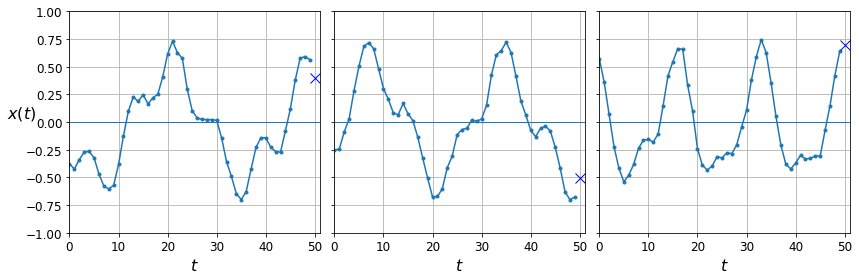

In [13]:
# plot the serires 

def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None))
save_fig("time_series_plot")
plt.show()

### Baseline Metrics 

In [14]:
# naive forcasting 
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.020211367

In [8]:
# linear prediction 

np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 1s 1ms/step - loss: 0.1026 - val_loss: 0.0556
Epoch 2/20
219/219 [==============================] - 0s 822us/step - loss: 0.0393 - val_loss: 0.0276
Epoch 3/20
219/219 [==============================] - 0s 772us/step - loss: 0.0209 - val_loss: 0.0163
Epoch 4/20
219/219 [==============================] - 0s 834us/step - loss: 0.0134 - val_loss: 0.0117
Epoch 5/20
219/219 [==============================] - 0s 739us/step - loss: 0.0104 - val_loss: 0.0099
Epoch 6/20
219/219 [==============================] - 0s 775us/step - loss: 0.0089 - val_loss: 0.0088
Epoch 7/20
219/219 [==============================] - 0s 749us/step - loss: 0.0080 - val_loss: 0.0079
Epoch 8/20
219/219 [==============================] - 0s 769us/step - loss: 0.0073 - val_loss: 0.0074
Epoch 9/20
219/219 [==============================] - 0s 783us/step - loss: 0.0067 - val_loss: 0.0067
Epoch 10/20
219/219 [==============================] - 0s 739us/step - loss: 0.0062 

In [9]:
### A simple RNN 

model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape = [None, 1])
])

# use hyperbolic tangent by default 

# set " return_sequences = True" to see all outputs 

### Trend and Seasonality 

In [10]:
# Other models: ARIMA models

# In some cases, remove teh trend and seasonality before train the model would imporve the outcome 

In [12]:
# try a deep rnns 

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences = True, input_shape = [None, 1]),
    keras.layers.SimpleRNN(20, return_sequences = True), 
    keras.layers.SimpleRNN(1)
])

model.compile(loss = "mse", optimizer = "adam") 

history = model.fit(X_train, y_train, epochs = 10, 
                   validation_data = (X_valid, y_valid))

Epoch 1/10
219/219 [==============================] - 5s 15ms/step - loss: 0.0185 - val_loss: 0.0053
Epoch 2/10
219/219 [==============================] - 3s 14ms/step - loss: 0.0042 - val_loss: 0.0039
Epoch 3/10
219/219 [==============================] - 3s 14ms/step - loss: 0.0034 - val_loss: 0.0033
Epoch 4/10
219/219 [==============================] - 3s 14ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 5/10
219/219 [==============================] - 3s 14ms/step - loss: 0.0031 - val_loss: 0.0032
Epoch 6/10
219/219 [==============================] - 3s 14ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 7/10
219/219 [==============================] - 3s 14ms/step - loss: 0.0029 - val_loss: 0.0031
Epoch 8/10
219/219 [==============================] - 3s 14ms/step - loss: 0.0029 - val_loss: 0.0030
Epoch 9/10
219/219 [==============================] - 3s 14ms/step - loss: 0.0029 - val_loss: 0.0029
Epoch 10/10
219/219 [==============================] - 3s 14ms/step - loss: 0.0029 - val_lo

### Predict the next 10 series 

In [15]:
# change the dataset 

series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

In [15]:
# make the output 10 

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

model.compile(loss = "mse", optimizer = "adam") 
history = model.fit(X_train, Y_train, epochs = 20, 
                   validation_data = (X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 3s 10ms/step - loss: 0.0579 - val_loss: 0.0259
Epoch 2/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0196 - val_loss: 0.0145
Epoch 3/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0142 - val_loss: 0.0149
Epoch 4/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0131 - val_loss: 0.0126
Epoch 5/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0121 - val_loss: 0.0113
Epoch 6/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0116 - val_loss: 0.0106
Epoch 7/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0109 - val_loss: 0.0101
Epoch 8/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0106 - val_loss: 0.0102
Epoch 9/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0105 - val_loss: 0.0096
Epoch 10/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0100 - val_loss: 

In [16]:
### Let make the each step predict the next ten step 

Y = np.empty((10000, n_steps, 10)) # each target is a sequence of 10D vectors 

for step_ahead in range(1, 10 + 1): 
    Y[:, :, step_ahead - 1] = series[:, step_ahead:step_ahead + n_steps, 0] 
    
Y_train = Y[:7000] 
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [17]:
# predict 10 in each step 

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss = "mse", optimizer = "adam") 
history = model.fit(X_train, Y_train, epochs = 20, 
                   validation_data = (X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 3s 11ms/step - loss: 0.0813 - val_loss: 0.0507
Epoch 2/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0463 - val_loss: 0.0418
Epoch 3/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0388 - val_loss: 0.0366
Epoch 4/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0359 - val_loss: 0.0342
Epoch 5/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0344 - val_loss: 0.0341
Epoch 6/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0341 - val_loss: 0.0329
Epoch 7/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0332 - val_loss: 0.0324
Epoch 8/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0326 - val_loss: 0.0317
Epoch 9/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0321 - val_loss: 0.0336
Epoch 10/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0319 - val_loss:

In [17]:
# a customize metric for this

def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

optimizer = keras.optimizers.Adam(lr = 0.01) 
model.compile(loss="mse", optimizer = optimizer, metrics = [last_time_step_mse])

C:\Users\JZ\anaconda3\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


### Handling Long Sequences 

In [18]:
# batch norm can't help a lot 

# 669 

# a simple rnn cell with batch norm 

class LNSimpleRNNCell(keras.layers.Layer): 
    def __init__(self, units, activation = "tanh", **kwargs): 
        super().__init__(**kwargs) 
        self.state_size = units 
        self.output_size = units 
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units, activation = None) 
        self.layer_norm = keras.layers.LayerNormalization() 
        self.activation = keras.activations.get(activation) 
    
    #apply  
    def call(self, inputs, states): 
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        # pass one as the outputs, one as the new hidden state 
        return norm_outputs, [norm_outputs]

In [19]:
# to use the model 

model = keras.models.Sequential([
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True,
    input_shape=[None, 1]),
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
    ])

### Tackling the short term memory problem 

In [20]:
# keras.layers.LSTM 

# keras.layers.RNN(keras.layers.LSTMCell())

# some use peephole connections "PeepholeLSTMCell" 

# P675

### GRU Cells

In [21]:
# keras.layers.GRU 


### Using 1D convoluional layers 

In [22]:
# use a 1d conv layer with a kernel_size = 4, and strides = 2, this will preserve the most info, 
# and summarize the most 

model = keras.models.Sequential([
    keras.layers.Conv1D(filters = 20, kernel_size = 4, strides = 2, padding = 'valid',
                       input_shape = [None, 1]),
    keras.layers.GRU(20, return_sequences = True),
    keras.layers.GRU(20, return_sequences = True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
    
])

# compile and run
model.compile(loss = "mse", optimizer = "adam", metrics = [last_time_step_mse]) 
history = model.fit(X_train, Y_train[:, 3::2], epochs = 20, 
                   validation_data = (X_valid, Y_valid[:, 3::2]))

Epoch 1/20
219/219 [==============================] - 15s 48ms/step - loss: 0.0667 - last_time_step_mse: 0.0587 - val_loss: 0.0446 - val_last_time_step_mse: 0.0363
Epoch 2/20
219/219 [==============================] - 11s 52ms/step - loss: 0.0398 - last_time_step_mse: 0.0323 - val_loss: 0.0342 - val_last_time_step_mse: 0.0268
Epoch 3/20
219/219 [==============================] - 8s 37ms/step - loss: 0.0320 - last_time_step_mse: 0.0236 - val_loss: 0.0288 - val_last_time_step_mse: 0.0192
Epoch 4/20
219/219 [==============================] - 10s 46ms/step - loss: 0.0274 - last_time_step_mse: 0.0174 - val_loss: 0.0255 - val_last_time_step_mse: 0.0145
Epoch 5/20
219/219 [==============================] - 9s 42ms/step - loss: 0.0247 - last_time_step_mse: 0.0139 - val_loss: 0.0234 - val_last_time_step_mse: 0.0128
Epoch 6/20
219/219 [==============================] - 13s 58ms/step - loss: 0.0231 - last_time_step_mse: 0.0124 - val_loss: 0.0224 - val_last_time_step_mse: 0.0117
Epoch 7/20
219/219

### WaveNet

In [23]:
# to deal with extreme long sequence 

In [24]:
# how to 
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
    activation="relu", dilation_rate=rate))
model.add(keras.layers.Conv1D(filters=10, kernel_size=1))
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])

In [25]:
history = model.fit(X_train, Y_train, epochs=20,
    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 7s 27ms/step - loss: 0.0675 - last_time_step_mse: 0.0554 - val_loss: 0.0363 - val_last_time_step_mse: 0.0226
Epoch 2/20
219/219 [==============================] - 6s 28ms/step - loss: 0.0333 - last_time_step_mse: 0.0196 - val_loss: 0.0300 - val_last_time_step_mse: 0.0173
Epoch 3/20
219/219 [==============================] - 6s 27ms/step - loss: 0.0294 - last_time_step_mse: 0.0164 - val_loss: 0.0276 - val_last_time_step_mse: 0.0149
Epoch 4/20
219/219 [==============================] - 6s 28ms/step - loss: 0.0275 - last_time_step_mse: 0.0146 - val_loss: 0.0276 - val_last_time_step_mse: 0.0152
Epoch 5/20
219/219 [==============================] - 6s 29ms/step - loss: 0.0265 - last_time_step_mse: 0.0138 - val_loss: 0.0259 - val_last_time_step_mse: 0.0134
Epoch 6/20
219/219 [==============================] - 6s 29ms/step - loss: 0.0256 - last_time_step_mse: 0.0129 - val_loss: 0.0252 - val_last_time_step_mse: 0.0127
Epoch 7/20
219/219 [==